# Imports & Initializations

In [4]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wa_parser

FILEPATH = r'./chats/wa_kristin.txt'
BACKGROUND_COLOR = '#f0efeb'
LOOKBACK_WEEKS = 104

plt.rcParams["font.family"] = ['Kristen ITC']
plt.rcParams["figure.facecolor"] = BACKGROUND_COLOR
plt.rcParams["axes.facecolor"] = BACKGROUND_COLOR
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.bottom"] = False

# Data Loading

In [5]:
from visualizations_setup import DATEFORMAT, TIMEFORMAT
df = wa_parser.get_df_from_chatlog(FILEPATH, dateformat = DATEFORMAT, \
                        timeformat = TIMEFORMAT)
df = df[df['datetime'] > df['datetime'].max() - pd.Timedelta(weeks=LOOKBACK_WEEKS)]
df["hour"] = df["datetime"].dt.hour

# Visualizations

## Messages per Day

In [6]:
df_daily_mess = df.groupby(by=df['datetime'].dt.date)['message'].count().reset_index()
df_daily_mess["messsagecount_rm28"] = df_daily_mess["message"].rolling(28, min_periods=13, center=True).mean()
df_daily_mess

,datetime,message,messsagecount_rm28
0,2021-01-06,1,4.714286
1,2021-01-07,6,5.066667
2,2021-01-13,4,5.062500
3,2021-01-14,2,5.000000
4,2021-01-17,7,4.777778
...,...,...,...
150,2021-12-08,1,4.473684
151,2021-12-10,1,4.388889
152,2021-12-13,2,4.470588
153,2021-12-16,3,4.500000


No handles with labels found to put in legend.


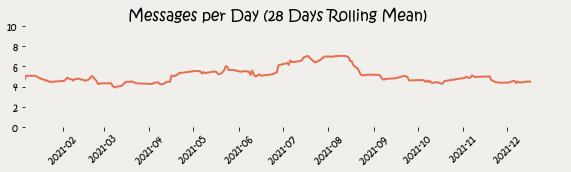

In [7]:
fig, ax = plt.subplots(figsize=(8,2.5))
sns.lineplot(data=df_daily_mess, x='datetime', y='messsagecount_rm28', ax=ax, color='#e76f51', lw=2)
ax.set_ylim(0,np.ceil(max(df_daily_mess['messsagecount_rm28'].values)/10)*10)
start_date = df_daily_mess.datetime.iat[0]
end_date = df_daily_mess.datetime.iat[-1]
#ax.set_xlim([datetime.date(2019, 11, 1), datetime.date(2021, 12, 1)])
ax.set_xlim([start_date, end_date])
ax.tick_params(axis='x', rotation=45)
ax.set_title("Messages per Day (28 Days Rolling Mean)", fontdict={"fontsize": 15})
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.legend(frameon = False, bbox_to_anchor=(1.04,0.5), loc="center left")
plt.tight_layout()

## Messages per Daytime

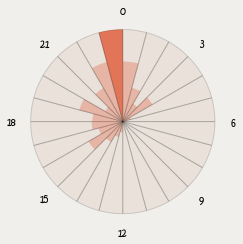

In [8]:
df_circle = df.groupby(by='hour')['message'].count().reset_index()

time = df_circle['hour']
count = df_circle['message']

c = np.zeros(24)
c[time] = count
count = c

f = plt.figure(figsize=(3.5, 3.5))
ax = plt.subplot(111, projection="polar")

x = np.arange(0, 2 * np.pi, 2 * np.pi / len(count)) + np.pi / len(count)

bars = ax.bar(x, count, width=2 * np.pi / len(count),
              alpha=0.4, color='#e76f51', bottom=0)

max_ind = np.argmax(count)
ax.bar(x[max_ind],count[max_ind], bottom=0,
       width=2 * np.pi / len(count), alpha=1, color='#e76f51')

ax.bar(x, np.max(count) * np.ones(len(count)), width=2 * np.pi / len(count),
    alpha=0.15, bottom=0, color='#cb997e', edgecolor="black")

ax.set_theta_direction(-1)
ax.grid(False)
ax.spines["polar"].set_visible(False)
ax.set_theta_offset(np.pi / 2)
ax.set_xticks(np.linspace(0, 2 * np.pi, 24, endpoint=False))
#ticks = ["12 AM", "", "", "3 AM", "", "", "6 AM", "", "", "9 AM",
#         "", "", "12 PM", "", "", "3 PM", "", "", "6 PM", "", "",
#         "9 PM", "", ""]
ticks = ["0", "", "", "3", "", "", "6", "", "", "9",
         "", "", "12", "", "", "15", "", "", "18", "", "",
         "21", "", ""]
ax.set_xticklabels(ticks)
plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout()

## WordCloud

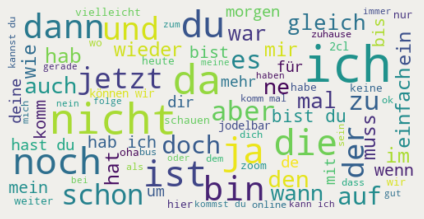

In [9]:
import os
from os import path
from wordcloud import WordCloud, STOPWORDS
from visualizations_setup import MEDIA_FLAG

messages = [str.join("", word.split(":")[1:]).split() for word in df["message"].values if not MEDIA_FLAG in word]
words = [word.lower() for sublist in messages for word in sublist]

stopwords = STOPWORDS.update(['media', 'omitted', 'missed', 'voice', 'call', 'http', 'https'])

wordcloud = WordCloud(stopwords=stopwords, max_font_size=60, width=500, height=250,
                      background_color='#f0efeb', colormap='viridis', min_word_length=2,
                      min_font_size=10).generate(' '.join(words))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()

In [10]:
from visualizations_setup import is_emoji, split_count
emoji_list = [word for word in words if any(is_emoji(char) for char in word)]
emoji_count = split_count(str.join(" ", emoji_list))
em = []
for key, value in emoji_count.items():
    for _ in range(value):
        em.append(key)
em

from visualizations_setup import replacements
emoji_text = "".join(em)
for key, value in replacements.items():
    emoji_text = emoji_text.replace(key, value)
emoji_text

'😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂🤷🤷🤷🤔🤔🤔🤔🤔🤔🤔😬😬😬😬😬😬😬😬😫💁🏼😱😱😱😭😭😭🙄🙄👍👍👍👍😅😅😅😅😅🤦🏼🤷🏼✌🏻😍😍😍😍😍😍😍😍😍😍😝😝😝😝😝😝😕😕😜😜😜😜😜😜😜😜😜😜😜😜😜😜👍🏻👍🏻👍🏻👍🏻👍🏻🙃🙃🙃🙃🤦😢👌😃😇😇😇🥺🥺😩😩🍦🍦😁😁😁😡😡❗️😟❓🚁🥑🤓🥔🍣🖕🖕🖕🖕🖕🖕🖕❤️❤️❤️❤️❤️❤️❤️👃🏻😉😉😮😳😘😘😘😘😋👅🌬🍻🍌🤢🏠😧🎉🎉🐝😤⛔⛔🚫😠🤬'

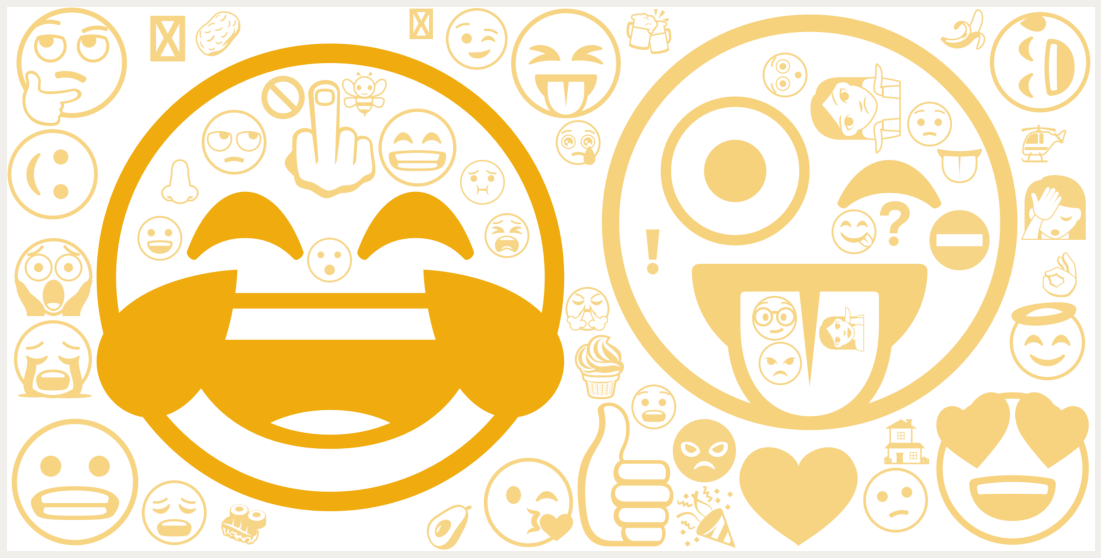

In [14]:
from visualizations_setup import EmojiCloud, FONT_PATH
emoji_cloud = EmojiCloud(font_path = FONT_PATH)
emoji_cloud.generate(emoji_text)

##### Statistics

In [ ]:
df["words"].sum()

In [ ]:
df.count()

In [ ]:
messages = [word.split() for word in df["message"].values]
words = [word.lower() for sublist in messages for word in sublist]
len(set(words))